In [1]:
import pandas as pd 
import numpy as np
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import math
import platform
import matplotlib
import datetime
import os

if platform.system() == 'Windows': 
    matplotlib.rc('font', family='Malgun Gothic') #한글 폰트 깨짐 방지
covid_data = pd.read_excel('covid19.xlsx',engine='openpyxl')
covid_data = covid_data.iloc[348:,[0,1,2,3,4]]

In [2]:
covid_data

,일자,확진자,국내발생,해외유입,사망
348,2021-01-01 00:00:00,1027,1002,25,17
349,2021-01-02 00:00:00,820,784,36,25
350,2021-01-03 00:00:00,657,641,16,20
351,2021-01-04 00:00:00,1020,986,34,19
352,2021-01-05 00:00:00,714,672,42,26
...,...,...,...,...,...
687,2021-12-06 00:00:00,4324,4295,29,41
688,2021-12-07 00:00:00,4954,4924,30,64
689,2021-12-08 00:00:00,7174,7140,34,63
690,2021-12-09 00:00:00,7102,7082,20,57


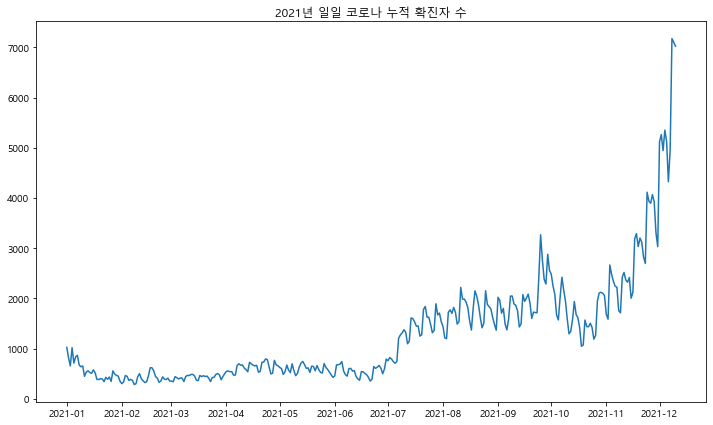

In [3]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
fig,ax1 = plt.subplots(figsize=(12,7))
ax1.set_title('2021년 일일 코로나 누적 확진자 수')
ax1.plot(covid_data['일자'],covid_data['확진자'])
x_ticks =['2021-01','2021-02','2021-03','2021-04','2021-05','2021-06','2021-07',
          '2021-08','2021-09','2021-10','2021-11','2021-12']
ax1.set_xticks(x_ticks)
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
ax1.xaxis.set_minor_formatter(mdates.DateFormatter("%Y-%m"))

In [4]:
dataset = covid_data[['확진자']].values
dataset = dataset.astype('float32')
print(dataset)

[[1027.]
 [ 820.]
 [ 657.]
 [1020.]
 [ 714.]
 [ 838.]
 [ 869.]
 [ 674.]
 [ 641.]
 [ 657.]
 [ 451.]
 [ 537.]
 [ 561.]
 [ 524.]
 [ 512.]
 [ 580.]
 [ 520.]
 [ 389.]
 [ 386.]
 [ 404.]
 [ 400.]
 [ 346.]
 [ 431.]
 [ 392.]
 [ 437.]
 [ 349.]
 [ 559.]
 [ 497.]
 [ 469.]
 [ 456.]
 [ 354.]
 [ 305.]
 [ 336.]
 [ 467.]
 [ 451.]
 [ 370.]
 [ 390.]
 [ 371.]
 [ 288.]
 [ 303.]
 [ 444.]
 [ 504.]
 [ 403.]
 [ 362.]
 [ 326.]
 [ 343.]
 [ 457.]
 [ 621.]
 [ 621.]
 [ 561.]
 [ 448.]
 [ 416.]
 [ 332.]
 [ 356.]
 [ 440.]
 [ 395.]
 [ 387.]
 [ 415.]
 [ 355.]
 [ 355.]
 [ 344.]
 [ 444.]
 [ 424.]
 [ 398.]
 [ 418.]
 [ 416.]
 [ 346.]
 [ 446.]
 [ 470.]
 [ 465.]
 [ 488.]
 [ 490.]
 [ 459.]
 [ 379.]
 [ 363.]
 [ 469.]
 [ 445.]
 [ 463.]
 [ 447.]
 [ 456.]
 [ 415.]
 [ 346.]
 [ 428.]
 [ 430.]
 [ 489.]
 [ 505.]
 [ 482.]
 [ 382.]
 [ 447.]
 [ 506.]
 [ 551.]
 [ 557.]
 [ 543.]
 [ 543.]
 [ 473.]
 [ 477.]
 [ 668.]
 [ 700.]
 [ 671.]
 [ 677.]
 [ 614.]
 [ 587.]
 [ 542.]
 [ 731.]
 [ 698.]
 [ 673.]
 [ 658.]
 [ 671.]
 [ 532.]
 [ 549.]
 [ 731.]
 

In [5]:
scale = MinMaxScaler(feature_range=(0, 1))
data_set = scale.fit_transform(dataset)
train, test = train_test_split(data_set,test_size=0.3,shuffle=False)
print(f'훈련 데이터 개수: {len(train)}, 테스트 데이터 개수: {len(test)}')

훈련 데이터 개수: 240, 테스트 데이터 개수: 104


In [6]:
def make_dataset(data, window):
    x_data = []
    y_data = []
    for i in range(len(data)-window-1):
        d = data[i:(i+window),0]
        x_data.append(d)
        y_data.append(data[i+window,0])
    return np.array(x_data), np.array(y_data)

In [7]:
size = 7
x_train, y_train = make_dataset(train, size)
x_test, y_test = make_dataset(test, size)
print(f'훈련 데이터 모습: x_train:{x_train.shape}, y_train:{y_train.shape}')
print(f'학습 데이터 모습: x_test:{x_test.shape}, y_test:{y_test.shape}')

훈련 데이터 모습: x_train:(232, 7), y_train:(232,)
학습 데이터 모습: x_test:(96, 7), y_test:(96,)


In [8]:
X_train = np.reshape(x_train, (x_train.shape[0],1,x_train.shape[1]))
X_test = np.reshape(x_test, (x_test.shape[0],1,x_test.shape[1]))
print(f'한 줄씩 쪼갠 훈련 데이터의 모습: X_train:{X_train.shape}')
print(f'한 줄씩 쪼갠 학습 데이터의 모습: X_test:{X_test.shape}')

한 줄씩 쪼갠 훈련 데이터의 모습: X_train:(232, 1, 7)
한 줄씩 쪼갠 학습 데이터의 모습: X_test:(96, 1, 7)


In [9]:
model = Sequential()
model.add(SimpleRNN(4,input_shape=(1,size)))
model.add(Dense(1,activation='linear'))
model.compile(loss='mse',optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 4)                 48        
_________________________________________________________________
dense (Dense)                (None, 1)                 5         
Total params: 53
Trainable params: 53
Non-trainable params: 0
_________________________________________________________________


In [10]:
model.fit(X_train,y_train,epochs=200,batch_size=3,verbose=1)

Epoch 1/200
78/78 [==============================] - 1s 842us/step - loss: 0.0083
Epoch 2/200
78/78 [==============================] - 0s 738us/step - loss: 0.0035
Epoch 3/200
78/78 [==============================] - 0s 648us/step - loss: 0.0022
Epoch 4/200
78/78 [==============================] - 0s 622us/step - loss: 0.0018
Epoch 5/200
78/78 [==============================] - 0s 596us/step - loss: 0.0016
Epoch 6/200
78/78 [==============================] - 0s 596us/step - loss: 0.0014
Epoch 7/200
78/78 [==============================] - 0s 609us/step - loss: 0.0013
Epoch 8/200
78/78 [==============================] - 0s 984us/step - loss: 0.0012
Epoch 9/200
78/78 [==============================] - 0s 777us/step - loss: 0.0011
Epoch 10/200
78/78 [==============================] - 0s 661us/step - loss: 9.8441e-04
Epoch 11/200
78/78 [==============================] - 0s 635us/step - loss: 9.3436e-04
Epoch 12/200
78/78 [==============================] - 0s 609us/step - loss: 8.1527e-04
E

78/78 [==============================] - 0s 622us/step - loss: 2.8113e-04
Epoch 96/200
78/78 [==============================] - 0s 635us/step - loss: 2.7704e-04
Epoch 97/200
78/78 [==============================] - 0s 648us/step - loss: 2.8078e-04
Epoch 98/200
78/78 [==============================] - 0s 1ms/step - loss: 2.9264e-04
Epoch 99/200
78/78 [==============================] - 0s 686us/step - loss: 2.7157e-04
Epoch 100/200
78/78 [==============================] - 0s 648us/step - loss: 2.7835e-04
Epoch 101/200
78/78 [==============================] - 0s 635us/step - loss: 2.8167e-04
Epoch 102/200
78/78 [==============================] - 0s 648us/step - loss: 2.8882e-04
Epoch 103/200
78/78 [==============================] - 0s 648us/step - loss: 2.9004e-04
Epoch 104/200
78/78 [==============================] - 0s 648us/step - loss: 2.7423e-04
Epoch 105/200
78/78 [==============================] - 0s 622us/step - loss: 2.8615e-04
Epoch 106/200
78/78 [==============================]

78/78 [==============================] - 0s 635us/step - loss: 2.6985e-04
Epoch 189/200
78/78 [==============================] - 0s 674us/step - loss: 2.7176e-04
Epoch 190/200
78/78 [==============================] - 0s 1ms/step - loss: 2.7339e-04
Epoch 191/200
78/78 [==============================] - 0s 881us/step - loss: 2.6340e-04
Epoch 192/200
78/78 [==============================] - 0s 583us/step - loss: 2.7173e-04
Epoch 193/200
78/78 [==============================] - 0s 596us/step - loss: 2.9399e-04
Epoch 194/200
78/78 [==============================] - 0s 622us/step - loss: 2.7915e-04
Epoch 195/200
78/78 [==============================] - 0s 609us/step - loss: 2.7739e-04
Epoch 196/200
78/78 [==============================] - 0s 622us/step - loss: 2.7351e-04
Epoch 197/200
78/78 [==============================] - 0s 596us/step - loss: 2.8709e-04
Epoch 198/200
78/78 [==============================] - 0s 622us/step - loss: 2.9464e-04
Epoch 199/200
78/78 [===========================

In [11]:
print(round(model.evaluate(X_test, y_test),5))

3/3 [==============================] - 0s 998us/step - loss: 0.0052
0.00521


In [12]:
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)
real_train_pred = scale.inverse_transform(train_pred)
Y_train = scale.inverse_transform([y_train]) 
real_test_pred = scale.inverse_transform(test_pred)
Y_test = scale.inverse_transform([y_test])
print(f'정규화가 적용된 훈련 예측값: {train_pred[50]} 실제 예측 값: {real_train_pred[50]}')
print(f'정규화가 적용된 학습 예측값: {test_pred[50]} 실제 예측 값: {real_test_pred[50]}')

정규화가 적용된 훈련 예측값: [0.01945705] 실제 예측 값: [421.98123]
정규화가 적용된 학습 예측값: [0.14086127] 실제 예측 값: [1257.9707]


In [15]:
train_acc =  math.sqrt(mean_squared_error(Y_train[0],real_train_pred[:,0]))
test_acc = math.sqrt(mean_squared_error(Y_test[0],real_test_pred[:,0]))
print('훈련 데이터 RMSE: {:.2f}'.format(train_acc))
print('학습 데이터 RMSE: {:.2f}'.format(test_acc))

훈련 데이터 RMSE: 110.50
학습 데이터 RMSE: 455.56


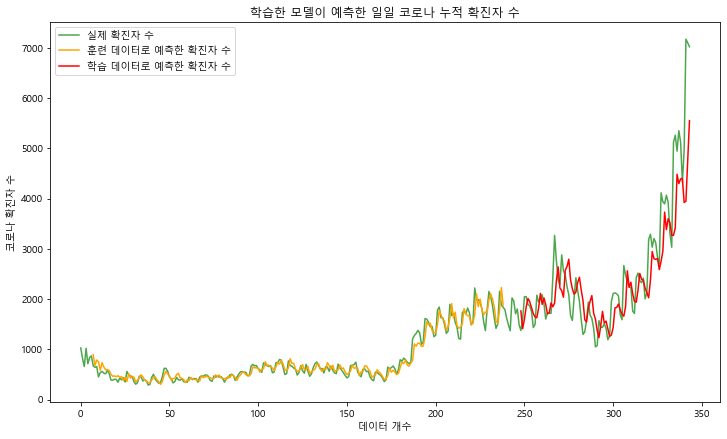

In [14]:
train_pred_plt = np.empty_like(dataset)
train_pred_plt[:,:] = np.nan
train_pred_plt[size:len(real_train_pred)+size,:] = real_train_pred

test_pred_plt = np.empty_like(dataset)
test_pred_plt[:,:] = np.nan
test_pred_plt[len(real_train_pred)+(size+1)*2:len(dataset), :] = real_test_pred

fig, ax2= plt.subplots(figsize=(12,7))
ax2.plot(train_pred_plt,test_pred_plt)
ax2.set_title('학습한 모델이 예측한 일일 코로나 누적 확진자 수')
plt.plot(dataset,label='실제 확진자 수',alpha=0.7,color='green')
plt.plot(train_pred_plt,label='훈련 데이터로 예측한 확진자 수',color='orange')
plt.plot(test_pred_plt,label='학습 데이터로 예측한 확진자 수',color='red')
ax2.set_xlabel('데이터 개수')
ax2.set_ylabel('코로나 확진자 수')
ax2.legend()